In [1]:
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
%matplotlib inline

### Parameters

In [2]:
# Генерим матрицу смежности графа для решения MAXCUT
np.random.seed(1234)
def generate_graph_matrix(n: int):
    #matrix = np.random.rand(n, n) * 100 # [0, 10] its good
    matrix = np.random.rand(n, n) #[0, 1] <- its bad
    # matrix = np.random.rand(n, n) * 0.1 # [0, 10] its good
    for i in range(n):
        matrix[i, i] = 0
    return matrix

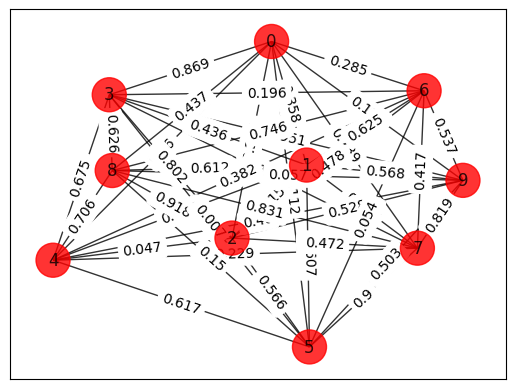

In [3]:
# N - кол-во вершин в графе, как следсвтие кол-во спинов
N = 10
# M - столько берем минимальных собственных чисел из состояних
# По идеи достаточно одного, но берем несколько для анализа того, 
# насколько у нас получилось хорошее решение
M = 20 # <= 2^N
matrix = generate_graph_matrix(N)
G = nx.from_numpy_array(matrix)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    edge_labels = dict(map(lambda p: (p[0], np.round(p[1], 3)), edge_labels.items()))
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [4]:
# taumax - максимальное время, можно увеличить для более адиабатического процесса
#taumax = 5.0
taumax = 50
taulist = np.linspace(0, taumax, 500) # 200 or 1000

### Precalculate operators

In [5]:
# Считаем базисы операторов
# sx, sy, sz - обычные матрицы Паули
# si - единичная матрица
si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

# sx_list - массив, где на k индексе стоит оператор \sigma^x_i = 
# (\otimes I)^k \sigma_x (\otimes I)^{n - k}, где n - кол-во спинов
# То есть sx_list - массив базисных операторов, у которых матрицу паули X умножили 
# слева и справа на нужное кол-во единичных матриц, чтобы получить 
# базисные операторы для состояние из n спинов
# sy_list, sz_list - все тоже самое, только Y и Z матрица Паули соотвественно
sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sx
    sx_list.append(qt.tensor(op_list))

    op_list[n] = sy
    sy_list.append(qt.tensor(op_list))

    op_list[n] = sz
    sz_list.append(qt.tensor(op_list))

### Construct the initial state

In [6]:
# qt.basic(n, k) - это |k⟩ ket из кетов |0⟩..|n-1⟩
psi_list = [(qt.basis(2, 0) + qt.basis(2, 1)) / np.sqrt(2) for n in range(N)]

psi0 = qt.tensor(psi_list) # initial ground state
H0 = 0
delta = 1 # просто коэффициент, можно менять, 
           # если хочется поменять начальное значение для лучшго схождения
for n in range(N):
    H0 -= 0.5 * delta * sx_list[n] # с sz вроде плохо работает
psi0

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (1024, 1), type = ket
Qobj data =
[[0.03125]
 [0.03125]
 [0.03125]
 ...
 [0.03125]
 [0.03125]
 [0.03125]]

In [7]:
# Выводим минимальное собственное число и соотвествуюзщий вектор
H0.eigenstates(eigvals=1)

(array([-5.]),
 array([Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (1024, 1), type = ket
        Qobj data =
        [[-0.03125]
         [-0.03125]
         [-0.03125]
         ...
         [-0.03125]
         [-0.03125]
         [-0.03125]]                                                                                                          ],
       dtype=object))

### Construct the Hamiltonian

In [8]:
# Готовим сложный гамильтониан на основе задачи
H1 = 0
H1 -= np.random.rand() * 0.01 * sz_list[0]
for i in range(N):
    for j in range(N):
        if (i == j):
            pass
        else:
            H1 += 0.5 * matrix[i, j] * sz_list[i] * sz_list[j] # + or -
# the time-dependent hamiltonian in list-function format
args = {"t_max": max(taulist)}
h_t = [
    [H0, lambda t, args: (args["t_max"] - t) / args["t_max"]],
    [H1, lambda t, args: t / args["t_max"]],
]

### Evolve the system in time

In [9]:
#
# callback function for each time-step
#
# evals_mat хранит в индексе t М минимальных собственных чисел в соотвествующем времени
evals_mat = np.zeros((len(taulist), M))
#evals_kets хранит ket c минимальной энергией для времени t
evals_kets = [None for _ in taulist]
# Хранит вероятности соотвествующего состояния
P_mat = np.zeros((len(taulist), M))
idx = [0]
last_psi = None

def process_rho(tau, psi):
    # Получаем гамильтаниан между начальным и конечным в зависимости от текущего времени
    H = qt.Qobj.evaluate(h_t, tau, args)

    # Получаем M минимальных собственных чисел и их кеты
    evals, ekets = H.eigenstates(eigvals=M)
    evals_mat[idx[0], :] = np.real(evals)
    evals_kets[idx[0]] = ekets[0]
    last_psi = psi

    # find the overlap between the eigenstates and psi
    for n, eket in enumerate(ekets):
        P_mat[idx[0], n] = abs((eket.dag().data * psi.data)[0, 0]) ** 2

    idx[0] += 1

Для большей информации, [документация функции mesolve](https://qutip.org/docs/4.0.2/modules/qutip/mesolve.html), часть про Time-dependent operators

Специальная функция, что эволюционирует начальное состояение psi0 с помощью гамильтаниана H, который зависит от времени. Она интегрирует, поэтому будет получатся долго для больших задач.

In [10]:
qt.mesolve(h_t, psi0, taulist, [], process_rho, args)

Result object with sesolve data.
--------------------------------
expect = True
num_expect = 1, num_collapse = 0

In [11]:
evals_mat[-1]

array([-5.6800151 , -5.66548193, -4.97743112, -4.96289795, -4.74044954,
       -4.72591637, -4.71493305, -4.70039988, -4.63983951, -4.62530635,
       -4.59850175, -4.58396858, -4.48930104, -4.47476787, -4.44112227,
       -4.4265891 , -4.42450189, -4.42191065, -4.42081265, -4.40996872])

In [12]:
P_mat[-1]

array([4.05506902e-01, 3.87124675e-01, 7.90118698e-02, 7.30178180e-02,
       1.03476457e-02, 9.59957151e-03, 8.00787972e-03, 7.95326363e-03,
       1.20708820e-03, 1.20496413e-03, 1.46262863e-03, 1.00805309e-03,
       2.39963193e-03, 2.10756134e-03, 5.75497787e-04, 4.87217733e-04,
       1.88122894e-03, 4.36233254e-04, 8.69121914e-05, 1.70743719e-03])

### Visualize the results

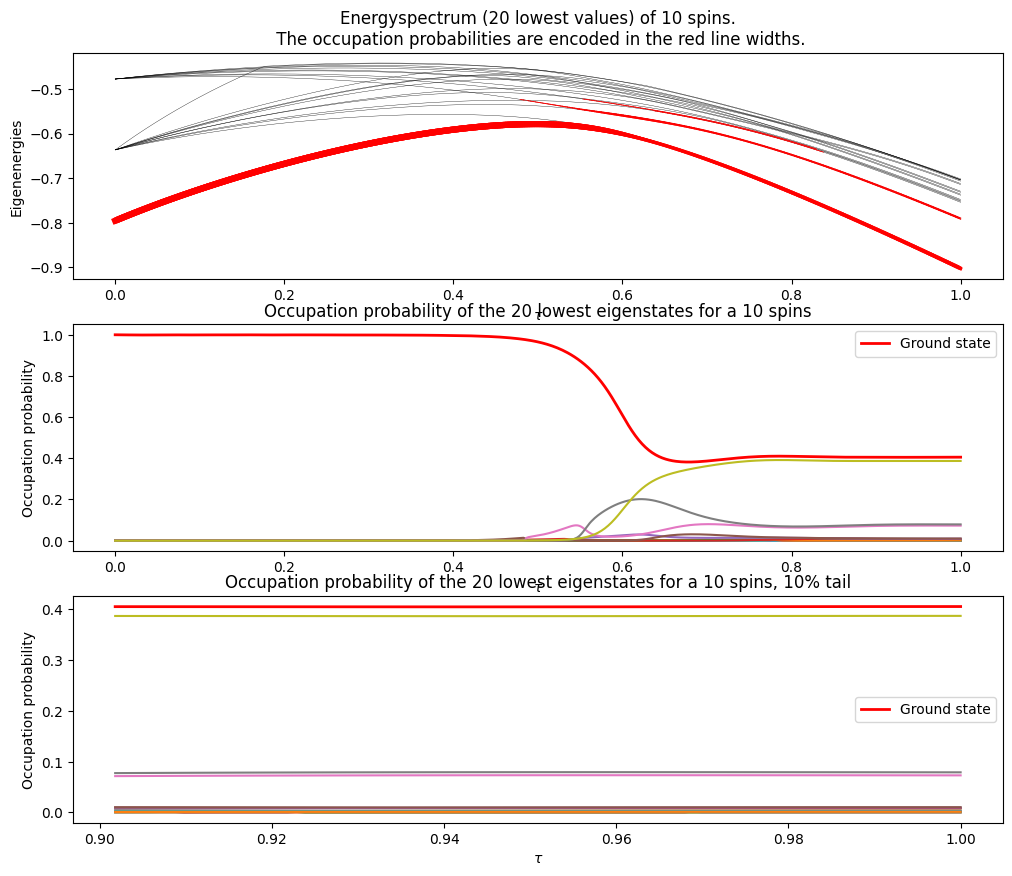

In [13]:
# rc('font', family='serif')
# rc('font', size='10')

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

#
# Рисуем график собственных значений энергий
#

# first draw thin lines outlining the energy spectrum
for n in range(len(evals_mat[0, :])):
    ls, lw = ("b", 1) if n == 0 else ("k", 0.25)
    axes[0].plot(taulist / max(taulist), evals_mat[:, n] / (2 * np.pi), ls,
                 lw=lw)

# second, draw line that encode the occupation probability of each state in
# its linewidth. thicker line => high occupation probability.
for idx in range(len(taulist) - 1):
    for n in range(len(P_mat[0, :])):
        lw = 0.5 + 4 * P_mat[idx, n]
        if lw > 0.55:
            axes[0].plot(
                np.array([taulist[idx], taulist[idx + 1]]) / taumax,
                np.array([evals_mat[idx, n], evals_mat[idx + 1, n]])
                / (2 * np.pi),
                "r",
                linewidth=lw,
            )

axes[0].set_xlabel(r"$\tau$")
axes[0].set_ylabel("Eigenenergies")
axes[0].set_title(
    "Energyspectrum (%d lowest values) of %d spins.\n " % (M, N)
    + "The occupation probabilities are encoded in the red line widths."
)

#
# plot the occupation probabilities for the few lowest eigenstates
#
for n in reversed(range(len(P_mat[0, :]))):
    if n == 0:
        axes[1].plot(taulist / max(taulist), 0 + P_mat[:, n], "r", linewidth=2, label="Ground state")
    else:
        axes[1].plot(taulist / max(taulist), 0 + P_mat[:, n])

axes[1].set_xlabel(r"$\tau$")
axes[1].set_ylabel("Occupation probability")
axes[1].set_title(
    "Occupation probability of the %d lowest " % M
    + "eigenstates for a %d spins" % N
)
axes[1].legend()

for n in reversed(range(len(P_mat[0, :]))):
    since = int(0.9 * P_mat.shape[0])
    if n == 0:
        axes[2].plot(taulist[since:] / max(taulist), 0 + P_mat[since:, n], "r", linewidth=2, label="Ground state")
    else:
        axes[2].plot(taulist[since:] / max(taulist), 0 + P_mat[since:, n])

axes[2].set_xlabel(r"$\tau$")
axes[2].set_ylabel("Occupation probability")
axes[2].set_title(
    "Occupation probability of the %d lowest " % M
    + "eigenstates for a %d spins, 10%% tail" % N
)
axes[2].legend()

Если графики выглядят нормально, то есть если изначальная минимальная энергия остается минимальной с большой вероятностью, то тогда ниже будет решение задачи

Иначе можно попробовать увеличить время(процесс должен быть достаточно медленным для адиабатического процесса), увеличить(умножить) веса у матрицы на константу, чтобы они стали больше(минимальное собственное число должно быть достаточно отдаленно от отстальных собственных чисел).

In [14]:
result = evals_kets[-1]
result # this is ket

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (1024, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

Давайте нарисуем ответ и проверим его брутфорсом(если граф достаточно маленький)

bin form of colors:  0100100111


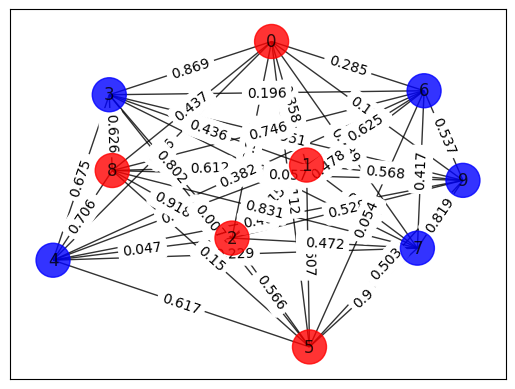

In [15]:
EPS = 1e-4
assert(1. - EPS < (result.dag() * result.conj())[0] < 1. + EPS) #module of ket is 1
index = -1
for i in range(2 ** N):
    if result[i] > 1. - EPS:
        index = i
assert(index != -1) # ket have only one 1.

print("bin form of colors: ", f"{index:0{N}b}")
buffer = index
color = np.zeros(N)
for i in range(N):
    color[i] = index % 2
    index //= 2
index = buffer
print 
colors = ["r" if color[node] else "b" for node in G.nodes()]
draw_graph(G, colors, pos)

In [16]:
max_weigth = 0
for i in range(N):
    for j in range(i):
        if color[i] != color[j]:
            max_weigth += matrix[i, j]
print("Weigth of maxcut: ", max_weigth)

Weigth of maxcut:  11.880351882230983


In [17]:
is_max = True
for cur_index in range(2 ** N):
    cur_color = np.zeros(N)
    weigth = 0
    for i in range(N):
        cur_color[i] = cur_index % 2
        cur_index //= 2
    for i in range(N):
        for j in range(i):
            if color[i] != color[j]:
                weigth += matrix[i, j]
    if weigth > max_weigth + EPS:
        is_max = False
        print("Not max solution!!!")
        print(f"For colors {index:0{N}b} weigth is {weigth}, which is bigger")
        break
if is_max:
    print("Solution is max")

Solution is max
